In [1]:
import xarray
import pygmt
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [2]:
ds = xarray.open_dataset("../data/MIROC_outputs/ctrl_MIROC-COSP2.nc")

In [3]:
%%capture

vname='vfall_T'
var=ds[vname]

In [4]:
#grids

lat=ds["latitude"].values
lon=ds["longitude"].values

temp=ds["lvtemp_grid"].values
zgrd=ds["lvdBZe_grid"].values
vgrd=ds["lvdplr_grid"].values

In [5]:
dx = vgrd[1] - vgrd[0]
x_edge = np.concatenate([
        [vgrd[0] - dx/2],
        vgrd + dx/2
        ])

dy = temp[1] - temp[0]
y_edge = np.concatenate([
         [temp[0] - dy/2],
         temp + dy/2
         ])

In [6]:
south=-20.
north=20.
east=360.
west=0.

# 0:ALL, 1:LSC, 2:CVC
regime=0

# n-th moment: 6(Ze), 3(mass), 0(number)
moment=3

In [7]:
vmin = 0.
vmax = 2.0
tick = 0.2

if moment==6:
    nmlz = 1
elif moment==3:
    nmlz = 2
elif moment==0:
    nmlz = 3

In [8]:
# location mask
lon_mask = (lon >= west) & (lon <= east)
lat_mask = (lat >= south)&(lat <= north)

mask = lon_mask & lat_mask

index = np.where(mask)[0]

In [9]:
sel = var.isel(loc=index).isel(regimeID=regime).isel(nrmlzdID=nmlz)
smpl = sel.sum(dim='loc', skipna=True).values
window = 0.2

In [10]:
nrm = window * smpl.sum(axis=1, keepdims=True)
nrm = np.broadcast_to(nrm,smpl.shape)

zero_check = (nrm < window)
cfed = np.zeros_like(smpl)

cfed[~zero_check] = smpl[~zero_check]/nrm[~zero_check]
cfed[zero_check] = np.nan

In [11]:
jmacolors=np.array(
   [
    [242,242,242,1],#white
    [160,210,255,1],
    [ 33,140,255,1],
    [  0, 65,255,1],
    [  0,185,  0,1],
    [250,245,  0,1],
    [255,153,  0,1],
    [255, 40,  0,1],
    [180,  0,104,1],
    [ 45, 45, 45,1],
   ],dtype=np.float64
)
jmacolors[:,:3] /=256
jmacmap=ListedColormap(jmacolors)
jmacmap2=LinearSegmentedColormap.from_list("jmacmap2",colors=jmacolors)

In [12]:
%%capture
plt.figure(figsize=(8, 6))

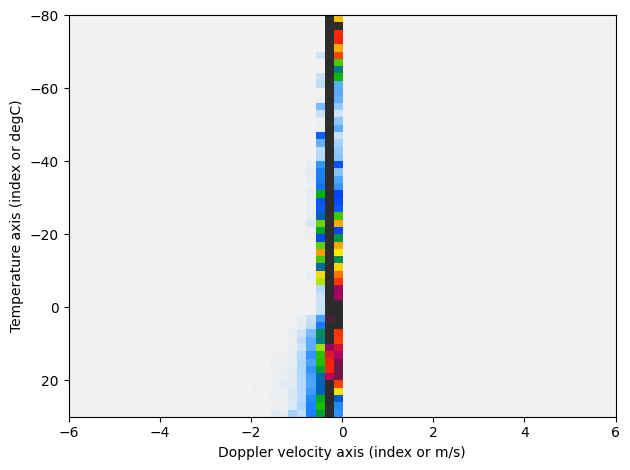

In [18]:
extent = [x_edge[0], x_edge[-1], y_edge[-1], y_edge[0]]

im = plt.imshow(cfed,
                extent=extent,
                interpolation='nearest',
                origin='upper',
                vmin=vmin, vmax=vmax,
                cmap=jmacmap2,
                aspect='auto')

plt.xlabel("Doppler velocity axis (index or m/s)")
plt.ylabel("Temperature axis (index or degC)")

plt.tight_layout()
plt.show()